In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

from enterprise_extensions.frequentist.optimal_statistic import OptimalStatistic as old_OptimalStatistic

from la_forge.core import Core

import sys
sys.path.append('../')

from defiant import OptimalStatistic
from defiant import utils
from defiant.extra import mdc1_utils

import scipy.linalg as sl

In [2]:
psrs, inj_params = mdc1_utils.create_MDC1_like_psrs(gwb_amplitude=1e-15,irn_amplitude=1e-15,seed=2232)

pta   = mdc1_utils.create_MDC1_PTA(psrs, include_irn=True, use_marginalizingtm=False)
m_pta = mdc1_utils.create_MDC1_PTA(psrs, include_irn=True, use_marginalizingtm=True)

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
OS_obj   = OptimalStatistic(psrs,pta=pta,gwb_name='gw')
m_OS_obj = OptimalStatistic(psrs,pta=m_pta,gwb_name='gw')

/Users/gersbaka/Documents/Projects/defiant/notebooks/../defiant/core.py:168: UserWarning: No MCMC samples were given! Set these later or supply them when computing the OS.


In [4]:
def solveD(N_obj, right, left):
    Nmat = N_obj.Nmat

    lNr = Nmat.solve(right, left_array=left)
    return lNr - np.tensordot(N_obj.MNF(left), N_obj.MNMMNF(right), (0, 0))

In [5]:
# new marginalizingTM code 1 (Using custom solve method with T)
def marginalizingTM_code1(pta, params):
    npsr = 36
    nfreq = 10

    X = np.zeros( shape = ( npsr, 2*nfreq ) ) # An array of vectors
    Z = np.zeros( shape = ( npsr, 2*nfreq, 2*nfreq ) ) # An array of matrices

    for a,psr_signal in enumerate(pta._signalcollections):
        phiinv = psr_signal.get_phiinv(params)
        if phiinv.ndim == 1:
            phiinv = np.diag(phiinv)

        r = psr_signal._residuals
        F = psr_signal['gw'].get_basis()
        T = psr_signal.get_basis()
        N = psr_signal.get_ndiag()


        FNr = solveD(N,r,F)
        TNr = solveD(N,r,T)
        FNF = solveD(N,F,F)
        FNT = solveD(N,T,F)
        TNT = solveD(N,T,T)

        sigma = phiinv + TNT
        try:
            cf = sl.cho_factor(sigma)
            X[a] = FNr - FNT @ sl.cho_solve(cf, TNr)
            Z[a] = FNF - FNT @ sl.cho_solve(cf, FNT.T)
        except np.linalg.LinAlgError:
            X[a] = FNr - FNT @ np.linalg.solve(sigma, TNr)
            Z[a] = FNF - FNT @ np.linalg.solve(sigma, FNT.T)

    return X, Z

# new marginalizingTM code 2 (Using ignoring non-gw frequencies)
def marginalizingTM_code2(pta, params):
    npsr = 36
    nfreq = 10

    X = np.zeros( shape = ( npsr, 2*nfreq ) ) # An array of vectors
    Z = np.zeros( shape = ( npsr, 2*nfreq, 2*nfreq ) ) # An array of matrices

    for a,psr_signal in enumerate(pta._signalcollections):
        phiinv = psr_signal.get_phiinv(params)[:2*nfreq]
        if phiinv.ndim == 1:
            phiinv = np.diag(phiinv)

        r = psr_signal._residuals
        F = psr_signal['gw'].get_basis()
        T = psr_signal.get_basis()
        N = psr_signal.get_ndiag()


        FNr = N.solve(r,F)
        FNF = N.solve(F,F)

        sigma = phiinv + FNF
        try:
            cf = sl.cho_factor(sigma)
            X[a] = FNr - FNF @ sl.cho_solve(cf, FNr)
            Z[a] = FNF - FNF @ sl.cho_solve(cf, FNF)
        except np.linalg.LinAlgError:
            X[a] = FNr - FNF @ np.linalg.solve(sigma, FNr)
            Z[a] = FNF - FNF @ np.linalg.solve(sigma, FNF)

    return X, Z

In [6]:
old_X, old_Z = OS_obj._compute_XZ(inj_params)
new_X1, new_Z1 = marginalizingTM_code1(m_pta,inj_params)
new_X2, new_Z2 = marginalizingTM_code2(m_pta,inj_params)

phihat = powerlaw(np.repeat(OS_obj.freqs,2),0,13./3.,1)
old_rho, old_sig = OS_obj._compute_rho_sig(old_X, old_Z, phihat)
new_rho1, new_sig1 = OS_obj._compute_rho_sig(new_X1, new_Z1, phihat)
new_rho2, new_sig2 = OS_obj._compute_rho_sig(new_X2, new_Z2, phihat)

xi,_ = utils.compute_pulsar_pair_separations(OS_obj.psrs)

In [7]:
print(np.allclose(new_X1, old_X))
print(np.allclose(new_Z1, old_Z))
print(np.allclose(new_X2, old_X))
print(np.allclose(new_Z2, old_Z))

True
True
False
False


In [8]:
print(np.allclose(new_rho1, old_rho))
print(np.allclose(new_sig1, old_sig))
print(np.allclose(new_rho2, old_rho))
print(np.allclose(new_sig2, old_sig))

True
True
True
True


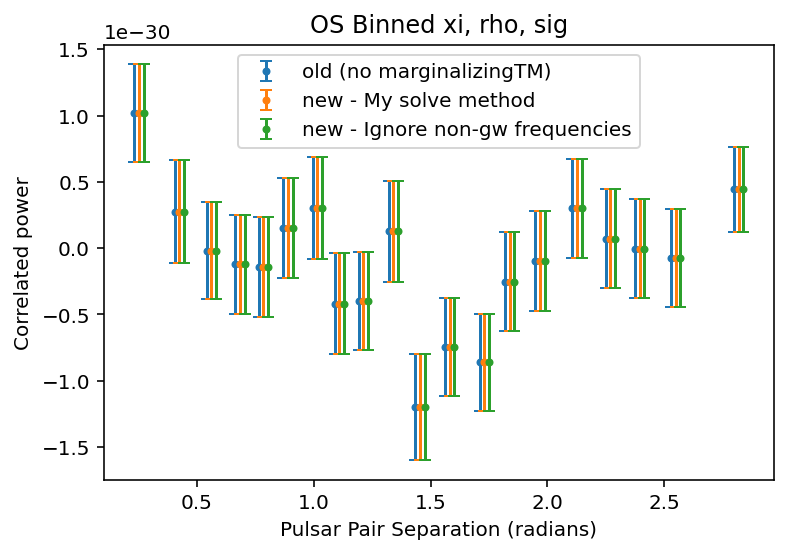

In [9]:
xia,rhoa,siga = utils.binned_pair_correlations(xi,old_rho,old_sig,20)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=3,label='old (no marginalizingTM)')

xia,rhoa,siga = utils.binned_pair_correlations(xi+0.02,new_rho1,new_sig1,20)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=3,label='new - My solve method')

xia,rhoa,siga = utils.binned_pair_correlations(xi+0.04,new_rho2,new_sig2,20)
plt.errorbar(xia,rhoa,siga,fmt='.',capsize=3,label='new - Ignore non-gw frequencies')
plt.legend()
plt.xlabel('Pulsar Pair Separation (radians)')
plt.ylabel('Correlated power')
plt.title('OS Binned xi, rho, sig')
plt.show()


In [10]:
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params,pair_covariance=True)
m_xi,m_rho,m_sig,m_C,m_A2,m_A2s = m_OS_obj.compute_OS(inj_params,pair_covariance=True)

print(np.allclose(rho,m_rho))
print(np.allclose(sig,m_sig))
print(np.allclose(C,m_C))
print(A2,m_A2)
print(A2s,m_A2s)

Pairs covariance elements: 100%|████| 198765/198765 [00:00<00:00, 500845.48it/s]


True
True
True
2.3791880003968356e-30 2.3791880003968675e-30
7.607321358857713e-31 7.607321358857717e-31


In [11]:
%timeit OS_obj.compute_OS(inj_params,pair_covariance=False)
%timeit m_OS_obj.compute_OS(inj_params,pair_covariance=False)

14.5 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.1 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
